# Heart

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier, XGBRegressor
import pickle
import joblib
from flask import Flask, jsonify, request


warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('./dataset/heart.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

### Defining Problem
Dataset berisikan bermacam - macam parameter yang mandakan apakah seseorang di diagnosa memiliki penyakit jantung.

Mengutip dari (https://www.cdc.gov/healthreport/publications/Compendium.pdf) halaman 1, terlihat pada grafik bahwa di tahun 2012 penyakit jantung berada di peringkat kedua penyebab kematian.

`Serangan jantung tidak selalu memiliki gejala`. Hal ini yang membuat kita tidak sadar akan resiko serangan jantung.

(https://www.bhf.org.uk/informationsupport/conditions/heart-attack)

### Defining Goals
Mendeteksi seseorang apakah memiliki potensi serangan jantung, tampa menunggu gejala serangan jantung.

### Describe Data

In [14]:
df.shape

(303, 14)

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,302.0,54.420530,9.047970,29.0,48.00,55.5,61.00,77.0
sex,302.0,0.682119,0.466426,0.0,0.00,1.0,1.00,1.0
cp,302.0,0.963576,1.032044,0.0,0.00,1.0,2.00,3.0
trestbps,302.0,131.602649,17.563394,94.0,120.00,130.0,140.00,200.0
chol,302.0,246.500000,51.753489,126.0,211.00,240.5,274.75,564.0
fbs,302.0,0.149007,0.356686,0.0,0.00,0.0,0.00,1.0
restecg,302.0,0.526490,0.526027,0.0,0.00,1.0,1.00,2.0
thalach,302.0,149.569536,22.903527,71.0,133.25,152.5,166.00,202.0
exang,302.0,0.327815,0.470196,0.0,0.00,0.0,1.00,1.0
oldpeak,302.0,1.043046,1.161452,0.0,0.00,0.8,1.60,6.2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


##### Penjelasan Kolom
- age = Usia
- sex = Jenis Kelamin (0=Perempuan, 1=Laki-laki)
- cp = Sakit dada (0=typical, 1=asymtotic, 2=nonanginal, 3=nontypical)
- trestbps = tekanan darah
- chol = kolesterol
- fbs = gula darah > 120mg/dl (0=false, 1=true)
- restecg = hasil ECG
- thalach = max heart rate
- exang = olahraga yang memerlukan angina (0=false, 1=true)
- oldpeak = tingkat deperesi dari stress test (ST)
- slope = slope tingkat tertinggi dari stress test (ST)
- ca = jumlah major vessels colored (0-3)
- thal = thalium stress result
- target = deteksi penyakit jantung

In [21]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


##### Handle Missing Value

In [8]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

##### Handle Duplicate Value

In [15]:
df[df.duplicated()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [16]:
df[df['age']==38]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
259,38,1,3,120,231,0,1,182,1,3.8,1,0,3,0


In [18]:
df.drop(164, inplace=True)

In [19]:
df[df.duplicated()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target


In [20]:
df[df['age']==38]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
259,38,1,3,120,231,0,1,182,1,3.8,1,0,3,0


### Handling Outliers

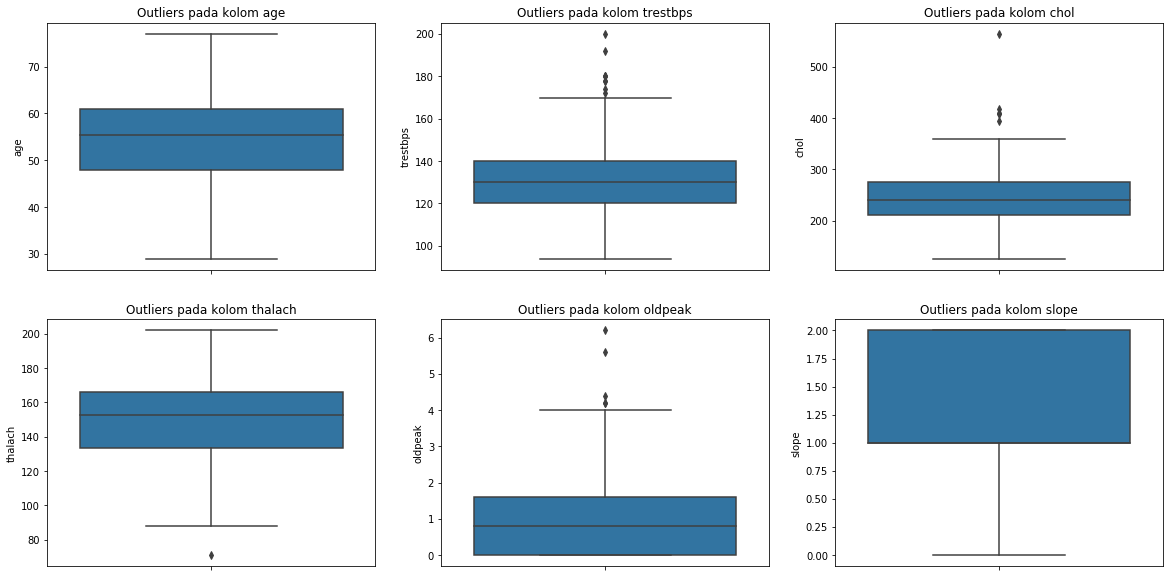

In [30]:
plt.figure('Mengecek Outliers dengan Boxplot', figsize=(20,10))

#Mengecek Outliers pada kolom age
plt.subplot(231)
plt.title('Outliers pada kolom age')
sns.boxplot(y=df["age"])

#Mengecek Outliers pada kolom trestbps
plt.subplot(232)
plt.title('Outliers pada kolom trestbps')
sns.boxplot(y=df["trestbps"])

#Mengecek Outliers pada kolom chol
plt.subplot(233)
plt.title('Outliers pada kolom chol')
sns.boxplot(y=df["chol"])

#Mengecek Outliers pada kolom thalach
plt.subplot(234)
plt.title('Outliers pada kolom thalach')
sns.boxplot(y=df["thalach"])

#Mengecek Outliers pada kolom oldpeak
plt.subplot(235)
plt.title('Outliers pada kolom oldpeak')
sns.boxplot(y=df["oldpeak"])

#Mengecek Outliers pada kolom slope
plt.subplot(236)
plt.title('Outliers pada kolom slope')
sns.boxplot(y=df["slope"])

plt.show()

#### outliers trestbps

In [37]:
Q1_trestbps = df.trestbps.quantile(0.25)
Q3_trestbps = df.trestbps.quantile(0.75)
IQR_trestbps = Q3_trestbps - Q1_trestbps
df[df['trestbps']>(Q3_trestbps + 1.5 * IQR_trestbps)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
101,59,1,3,178,270,0,0,145,0,4.2,0,0,3,1
110,64,0,0,180,325,0,1,154,1,0.0,2,0,2,1
203,68,1,2,180,274,1,0,150,1,1.6,1,0,3,0
223,56,0,0,200,288,1,0,133,1,4.0,0,2,3,0
241,59,0,0,174,249,0,1,143,1,0.0,1,0,2,0
248,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0
260,66,0,0,178,228,1,1,165,1,1.0,1,2,3,0
266,55,0,0,180,327,0,2,117,1,3.4,1,0,2,0


In [38]:
(Q3_trestbps + 1.5 * IQR_trestbps)

170.0

##### Outliers pada trestbps
Outliers (trestbps > 170) dirasa penting karena memiliki target yang bervariasi

#### outliers chol

In [39]:
Q1_chol = df.chol.quantile(0.25)
Q3_chol = df.chol.quantile(0.75)
IQR_chol = Q3_chol - Q1_chol
df[df['chol']>(Q3_chol + 1.5 * IQR_chol)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
28,65,0,2,140,417,1,0,157,0,0.8,2,1,2,1
85,67,0,2,115,564,0,0,160,0,1.6,1,0,3,1
96,62,0,0,140,394,0,0,157,0,1.2,1,0,2,1
220,63,0,0,150,407,0,0,154,0,4.0,1,3,3,0
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3,0


In [41]:
(Q3_chol + 1.5 * IQR_chol)

370.375

In [116]:
df.drop(85, inplace=True)

##### Outliers pada chol
Outliers pada kolom kolesterol (chol > 370.375) memiliki output target yang bervariasi. Namun ada 1 data (index= 85) yang memiliki value chol terlalu jauh sehingga lebih baik di drop. Sisa nya dibiarkan.

#### outliers thalach

In [44]:
Q1_thalach = df.thalach.quantile(0.25)
Q3_thalach = df.thalach.quantile(0.75)
IQR_thalach = Q3_thalach - Q1_thalach
df[df['thalach']<(Q1_thalach - 1.5 * IQR_thalach)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
272,67,1,0,120,237,0,1,71,0,1.0,1,0,2,0


In [47]:
(Q1_thalach - 1.5 * IQR_thalach)

84.125

In [46]:
df.sort_values(by=['thalach'])

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
272,67,1,0,120,237,0,1,71,0,1.0,1,0,2,0
243,57,1,0,152,274,0,1,88,1,1.2,1,1,3,0
297,59,1,0,164,176,1,0,90,0,1.0,1,2,1,0
262,53,1,0,123,282,0,1,95,1,2.0,1,2,3,0
136,60,0,2,120,178,1,1,96,0,0.0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,52,1,3,118,186,0,0,190,0,0.0,1,0,1,1
125,34,0,1,118,210,0,1,192,0,0.7,2,0,2,1
103,42,1,2,120,240,1,1,194,0,0.8,0,0,3,1
248,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0


In [48]:
df.drop(272, inplace=True)

##### Outliers pada thalach (max heart rate)
Outliers (thalach < 84.125) pada kolom thalac hanya ada satu dan memiliki gap yang cukup besar dengan data selanjutnya. Supaya tidak merusak range nantinya, maka lebih baik outliers ini di drop.

#### outliers oldpeak

In [49]:
Q1_oldpeak = df.oldpeak.quantile(0.25)
Q3_oldpeak = df.oldpeak.quantile(0.75)
IQR_oldpeak = Q3_oldpeak - Q1_oldpeak
df[df['oldpeak']>(Q3_oldpeak + 1.5 * IQR_oldpeak)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
101,59,1,3,178,270,0,0,145,0,4.2,0,0,3,1
204,62,0,0,160,164,0,0,145,0,6.2,0,3,3,0
221,55,1,0,140,217,0,1,111,1,5.6,0,0,3,0
250,51,1,0,140,298,0,1,122,1,4.2,1,3,3,0
291,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0


In [50]:
(Q3_oldpeak + 1.5 * IQR_oldpeak)

4.0

In [53]:
df.sort_values(by=['oldpeak'],ascending=False)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
204,62,0,0,160,164,0,0,145,0,6.2,0,3,3,0
221,55,1,0,140,217,0,1,111,1,5.6,0,0,3,0
291,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
101,59,1,3,178,270,0,0,145,0,4.2,0,0,3,1
250,51,1,0,140,298,0,1,122,1,4.2,1,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,60,0,2,120,178,1,1,96,0,0.0,2,0,2,1
137,62,1,1,128,208,1,0,140,0,0.0,2,0,2,1
142,42,0,2,120,209,0,1,173,0,0.0,1,0,2,1
145,70,1,1,156,245,0,0,143,0,0.0,2,0,2,1


##### Outliers pada oldpeak (tingkat deperesi dari stress test)
Outliers pada kolom oldpeak (oldpeak > 4) masih dirasa penting karena memiliki nilai target yang berbeda - beda sehingga lebih baik dibiarkan

#### Boxplot setelah Handling Outliers

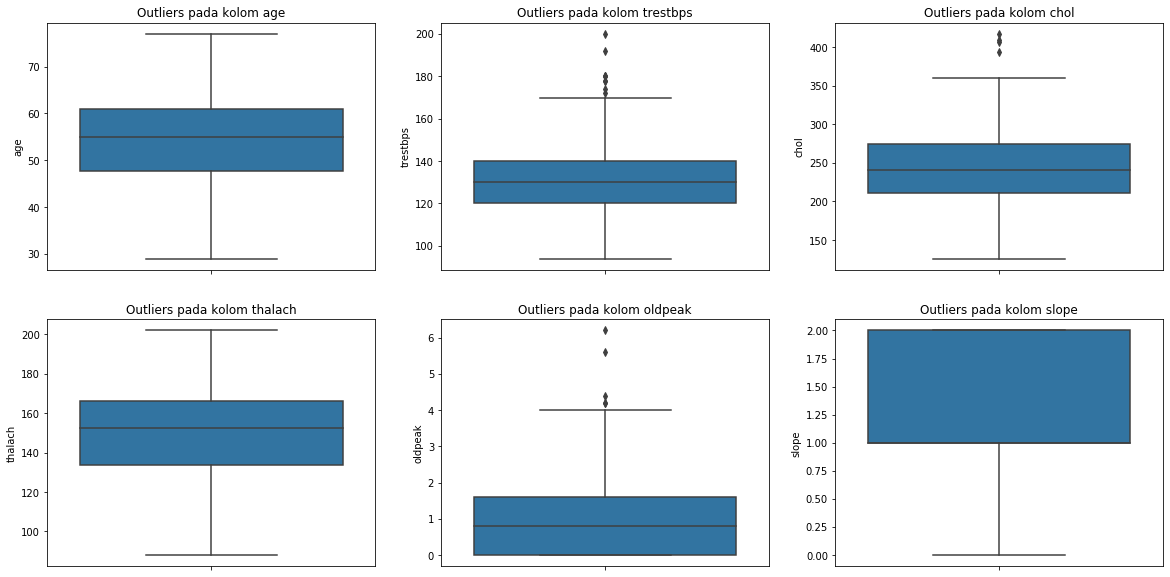

In [117]:
plt.figure('Mengecek Outliers dengan Boxplot', figsize=(20,10))

#Mengecek Outliers pada kolom age
plt.subplot(231)
plt.title('Outliers pada kolom age')
sns.boxplot(y=df["age"])

#Mengecek Outliers pada kolom trestbps
plt.subplot(232)
plt.title('Outliers pada kolom trestbps')
sns.boxplot(y=df["trestbps"])

#Mengecek Outliers pada kolom chol
plt.subplot(233)
plt.title('Outliers pada kolom chol')
sns.boxplot(y=df["chol"])

#Mengecek Outliers pada kolom thalach
plt.subplot(234)
plt.title('Outliers pada kolom thalach')
sns.boxplot(y=df["thalach"])

#Mengecek Outliers pada kolom oldpeak
plt.subplot(235)
plt.title('Outliers pada kolom oldpeak')
sns.boxplot(y=df["oldpeak"])

#Mengecek Outliers pada kolom slope
plt.subplot(236)
plt.title('Outliers pada kolom slope')
sns.boxplot(y=df["slope"])

plt.show()

### Handling Imbalance Data

In [55]:
df.target.value_counts()

1    164
0    137
Name: target, dtype: int64

In [56]:
(df.target.value_counts()/len(df))*100

1    54.48505
0    45.51495
Name: target, dtype: float64

Data dirasa cukup `balance` karena memiliki perbandingan 45% : 55% sehingga tidak perlu di handle imbalanca data lagi

### Data Analysis

In [58]:
pd.crosstab(index=df.target,columns='total')

col_0,total
target,
0,137
1,164


In [59]:
pd.crosstab(index=df.target,columns=df.sex)

sex,0,1
target,,
0,24,113
1,72,92


Sex --> 0 = female, 1 = male

In [60]:
#Chest Pain
pd.crosstab(index=df.cp,columns='total')

col_0,total
cp,
0,142
1,50
2,86
3,23


In [61]:
pd.crosstab(index=df.target,columns=df.cp)

cp,0,1,2,3
target,,,,
0,103,9,18,7
1,39,41,68,16


In [65]:
# %Typical Chest Pain
(39/(39+103))*100

27.464788732394368

27% orang yang merasakan typical chest pain terkena serangan jantung. Namun, typical chest pain memiliki resiko penyakit jantung terendah dibanding dengan chest pain lainnya

In [80]:
pd.pivot_table(data=df, index='sex', columns='target', values='chol', aggfunc='mean').round(2)

target,0,1
sex,,
0,274.96,256.75
1,246.14,231.60


In [69]:
(pd.crosstab(index=df.target,columns='Rata-rata', values=df.thalach, aggfunc='mean')).round(2)

col_0,Rata-rata
target,
0,139.60
1,158.38


Terlihat disini, orang dengan max heart rate tinggi lebih berpotensi untuk terkena serangan jantung

In [70]:
(pd.crosstab(index=df.target,columns='Rata-rata', values=df.trestbps, aggfunc='mean')).round(2)

col_0,Rata-rata
target,
0,134.50
1,129.25


In [83]:
pd.pivot_table(data=df, index='age', columns='target', values='thalach', aggfunc='mean').round(2)

target,0,1
age,,
29,NaN,202.00
34,NaN,183.00
35,143.00,178.00
37,NaN,178.50
38,182.00,173.00
39,140.00,171.00
40,147.50,178.00
41,158.00,165.44
42,125.00,165.29


### Data Visualization

##### Age
Persebaran umur pada dataset

<Figure size 432x288 with 0 Axes>

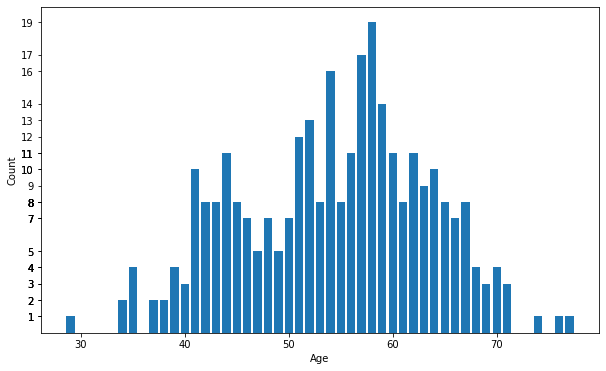

In [90]:
df_age = df['age'].value_counts().reset_index()
df_age = df_age.rename(columns={"age": "count"})
df_age = df_age.rename(columns={"index": "Age"})

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(df_age['Age'],df_age['count'])
ax.set_yticks(df_age['count'])
ax.set_xlabel('Age')
ax.set_ylabel('Count')
plt.show()

##### Persebaran Age di target 1

<Figure size 432x288 with 0 Axes>

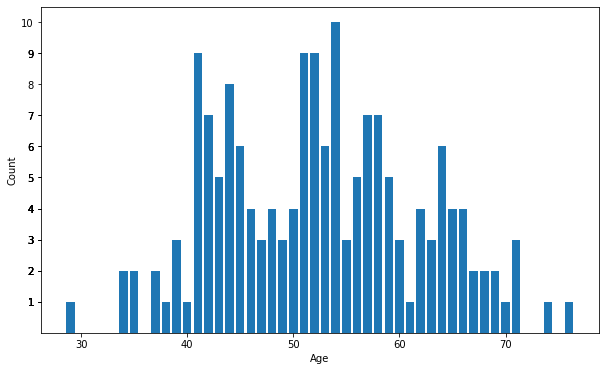

In [184]:
df_age1 = df[df['target']==1]['age'].value_counts().reset_index()
df_age1 = df_age1.rename(columns={"age": "count"})
df_age1 = df_age1.rename(columns={"index": "Age"})

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(df_age1['Age'],df_age1['count'])
ax.set_yticks(df_age1['count'])
ax.set_xlabel('Age')
ax.set_ylabel('Count')
plt.show()

##### Persebaran Age di target 0

<Figure size 432x288 with 0 Axes>

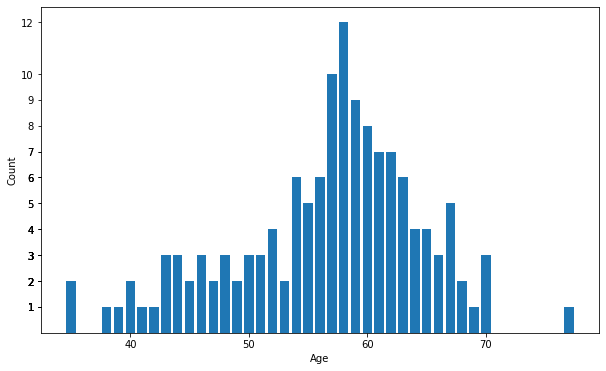

In [186]:
df_age0 = df[df['target']==0]['age'].value_counts().reset_index()
df_age0 = df_age0.rename(columns={"age": "count"})
df_age0 = df_age0.rename(columns={"index": "Age"})

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(df_age0['Age'],df_age0['count'])
ax.set_yticks(df_age0['count'])
ax.set_xlabel('Age')
ax.set_ylabel('Count')
plt.show()

#### Sex

In [196]:
(df.sex.value_counts()/len(df))*100

1    68.333333
0    31.666667
Name: sex, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

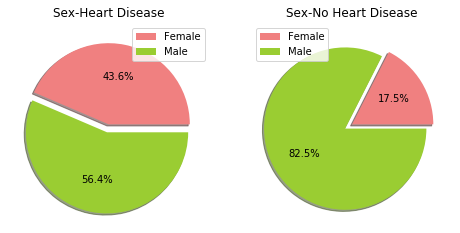

In [192]:
sex_F = df[(df['sex']== 0)&(df['target']==1)]['sex'].count()
sex_M = df[(df['sex']== 1)&(df['target']==1)]['sex'].count()

sex_F0 = df[(df['sex']== 0)&(df['target']==0)]['sex'].count()
sex_M0 = df[(df['sex']== 1)&(df['target']==0)]['sex'].count()


persentase = [sex_F,sex_M]
persentase0 = [sex_F0,sex_M0]
name = ['Female','Male']
colors = ['lightcoral','yellowgreen']

plt.figure('Sex', figsize=(8,5))
plt.subplot(121)
plt.pie(
    persentase,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.1)
)
plt.title('Sex-Heart Disease')
plt.legend(labels=name, loc="best")

plt.figure('Sex', figsize=(8,5))
plt.subplot(122)
plt.pie(
    persentase0,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.1)
)
plt.title('Sex-No Heart Disease')
plt.legend(labels=name, loc="best")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

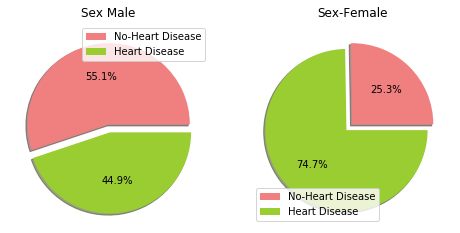

In [194]:
sex_M_0 = df[(df['sex']== 1)&(df['target']==0)]['sex'].count()
sex_M_1 = df[(df['sex']== 1)&(df['target']==1)]['sex'].count()

sex_F_0 = df[(df['sex']== 0)&(df['target']==0)]['sex'].count()
sex_F_1 = df[(df['sex']== 0)&(df['target']==1)]['sex'].count()


persentase = [sex_M_0,sex_M_1]
persentase0 = [sex_F_0,sex_F_1]
name = ['No-Heart Disease','Heart Disease']
colors = ['lightcoral','yellowgreen']

plt.figure('Sex', figsize=(8,5))
plt.subplot(121)
plt.pie(
    persentase,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.1)
)
plt.title('Sex Male')
plt.legend(labels=name, loc="best")

plt.figure('Sex', figsize=(8,5))
plt.subplot(122)
plt.pie(
    persentase0,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.1)
)
plt.title('Sex-Female')
plt.legend(labels=name, loc="best")
plt.show

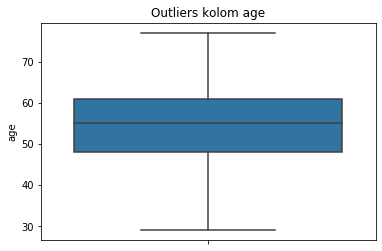

In [97]:
plt.title('Outliers kolom age')
sns.boxplot(y=df["age"])

plt.show()

#### Chest Pain

<function matplotlib.pyplot.show(*args, **kw)>

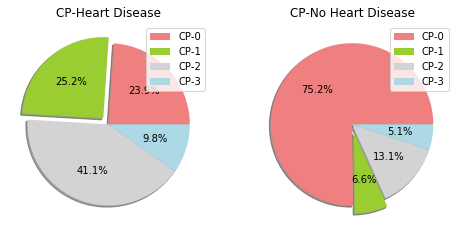

In [183]:
cp0 = df[(df['cp']== 0)&(df['target']==1)]['cp'].count()
cp1 = df[(df['cp']== 1)&(df['target']==1)]['cp'].count()
cp2 = df[(df['cp']== 2)&(df['target']==1)]['cp'].count()
cp3 = df[(df['cp']== 3)&(df['target']==1)]['cp'].count()

cp00 = df[(df['cp']== 0)&(df['target']==0)]['cp'].count()
cp10 = df[(df['cp']== 1)&(df['target']==0)]['cp'].count()
cp20 = df[(df['cp']== 2)&(df['target']==0)]['cp'].count()
cp30 = df[(df['cp']== 3)&(df['target']==0)]['cp'].count()


persentase = [cp0,cp1,cp2,cp3]
persentase0 = [cp00,cp10,cp20,cp30]
name = ['CP-0','CP-1','CP-2', 'CP-3']
colors = ['lightcoral','yellowgreen','lightgrey','lightblue']

plt.figure('CP', figsize=(8,5))
plt.subplot(121)
plt.pie(
    persentase,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.1,0,0)
)
plt.title('CP-Heart Disease')
plt.legend(labels=name, loc="best")

plt.figure('CP', figsize=(8,5))
plt.subplot(122)
plt.pie(
    persentase0,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.1,0,0)
)
plt.title('CP-No Heart Disease')
plt.legend(labels=name, loc="best")
plt.show

In [93]:
df.cp.value_counts()

0    142
2     86
1     50
3     23
Name: cp, dtype: int64

#### trestbps

In [ ]:
# cel = sns.FacetGrid(df, col="target", hue='sex', palette='rainbow')
# cel.map(plt.scatter, "age","trestbps").add_legend()

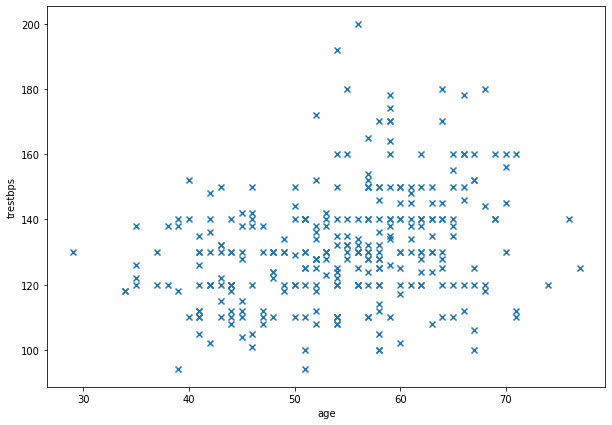

In [197]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(df['age'],df['trestbps'], marker='x')
ax.set_ylabel('trestbps')
ax.set_xlabel('age')
plt.show()

#### Chol

In [106]:
df.chol.value_counts()

234    6
197    6
204    6
212    5
254    5
      ..
281    1
284    1
290    1
293    1
564    1
Name: chol, Length: 151, dtype: int64

##### Persebaran Kolesterol di Target 1

<Figure size 432x288 with 0 Axes>

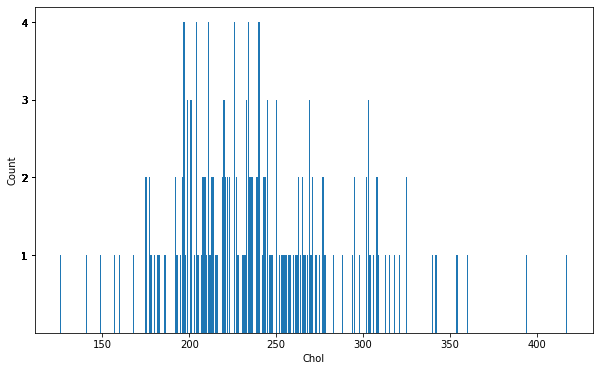

In [200]:
df_chol1 = df[df['target']==1]['chol'].value_counts().reset_index()
df_chol1 = df_chol1.rename(columns={"chol": "count"})
df_chol1 = df_chol1.rename(columns={"index": "Chol"})

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(df_chol1['Chol'],df_chol1['count'])
ax.set_yticks(df_chol1['count'])
ax.set_xlabel('Chol')
ax.set_ylabel('Count')
plt.show()

##### Persebaran Kolesterol di Target 0

<Figure size 432x288 with 0 Axes>

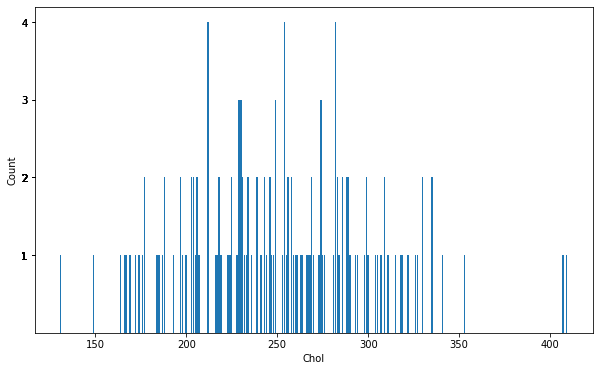

In [201]:
df_chol0 = df[df['target']==0]['chol'].value_counts().reset_index()
df_chol0 = df_chol0.rename(columns={"chol": "count"})
df_chol0 = df_chol0.rename(columns={"index": "Chol"})

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(df_chol0['Chol'],df_chol0['count'])
ax.set_yticks(df_chol0['count'])
ax.set_xlabel('Chol')
ax.set_ylabel('Count')
plt.show()

In [ ]:
df_chol = df['chol'].value_counts().reset_index()
df_chol = df_chol.rename(columns={"chol": "count"})
df_chol = df_chol.rename(columns={"index": "Chol"})

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(df_chol['Chol'],df_chol['count'])
ax.set_yticks(df_chol['count'])
ax.set_xlabel('Chol')
ax.set_ylabel('Count')
plt.show()

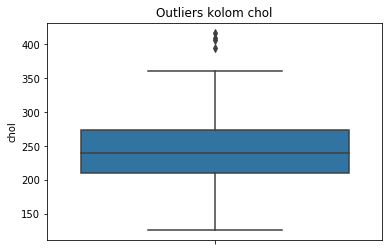

In [118]:
plt.title('Outliers kolom chol')
sns.boxplot(y=df["chol"])

plt.show()

#### fbs (blood sugar)

<function matplotlib.pyplot.show(*args, **kw)>

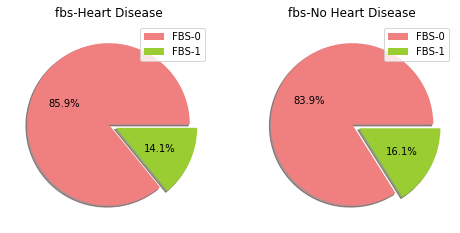

In [204]:
fbs0 = df[(df['fbs']== 0)&(df['target']==1)]['fbs'].count()
fbs1 = df[(df['fbs']== 1)&(df['target']==1)]['fbs'].count()

fbs00 = df[(df['fbs']== 0)&(df['target']==0)]['fbs'].count()
fbs01 = df[(df['fbs']== 1)&(df['target']==0)]['fbs'].count()


persentase = [fbs0,fbs1]
persentase0 = [fbs00,fbs01]
name = ['FBS-0','FBS-1']
colors = ['lightcoral','yellowgreen']

plt.figure('fbs', figsize=(8,5))
plt.subplot(121)
plt.pie(
    persentase,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.1)
)
plt.title('fbs-Heart Disease')
plt.legend(labels=name, loc="best")

plt.figure('fbs', figsize=(8,5))
plt.subplot(122)
plt.pie(
    persentase0,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.1)
)
plt.title('fbs-No Heart Disease')
plt.legend(labels=name, loc="best")
plt.show

#### restecg

In [119]:
df.restecg.value_counts()

1    150
0    146
2      4
Name: restecg, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

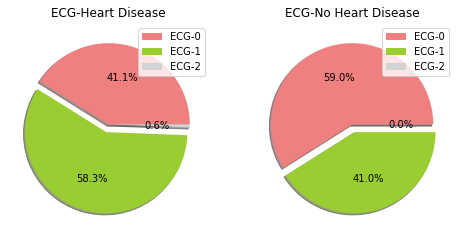

In [173]:
restecg0 = df[(df['restecg']== 0)&(df['target']==1)]['restecg'].count()
restecg1 = df[(df['restecg']==1)&(df['target']==1)]['restecg'].count()
restecg2 = df[(df['restecg']==2)&(df['target']==1)]['restecg'].count()

restecg00 = df[(df['restecg']== 0)&(df['target']==0)]['restecg'].count()
restecg10 = df[(df['restecg']==1)&(df['target']==0)]['restecg'].count()
restecg20 = df[(df['restecg']==2)&(df['target']==9)]['restecg'].count()

persentase = [restecg0,restecg1,restecg2]
persentase0 = [restecg00,restecg10,restecg20]
name = ['ECG-0','ECG-1','ECG-2']
colors = ['lightcoral','yellowgreen','lightgrey']

plt.figure('ECG', figsize=(8,5))
plt.subplot(121)
plt.pie(
    persentase,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.1,0)
)
plt.title('ECG-Heart Disease')
plt.legend(labels=name, loc="best")


plt.figure('ECG', figsize=(8,5))
plt.subplot(122)
plt.pie(
    persentase0,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.1,0)
)
plt.title('ECG-No Heart Disease')
plt.legend(labels=name, loc="best")
plt.show

#### thalach

##### Persebaran thalach di seluruh dataset

<Figure size 432x288 with 0 Axes>

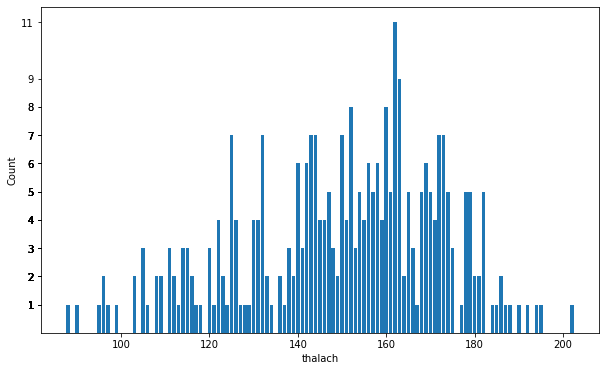

In [126]:
df_thalach = df['thalach'].value_counts().reset_index()
df_thalach = df_thalach.rename(columns={"thalach": "count"})
df_thalach = df_thalach.rename(columns={"index": "thalach"})

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(df_thalach['thalach'],df_thalach['count'])
ax.set_yticks(df_thalach['count'])
ax.set_xlabel('thalach')
ax.set_ylabel('Count')
plt.show()

##### Persebaran thalach di target 1

<Figure size 432x288 with 0 Axes>

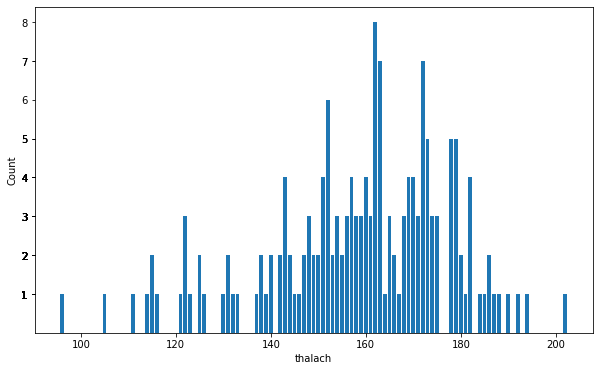

In [206]:
df_thalach1 = df[df['target']==1]['thalach'].value_counts().reset_index()
df_thalach1 = df_thalach1.rename(columns={"thalach": "count"})
df_thalach1 = df_thalach1.rename(columns={"index": "thalach"})

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(df_thalach1['thalach'],df_thalach1['count'])
ax.set_yticks(df_thalach1['count'])
ax.set_xlabel('thalach')
ax.set_ylabel('Count')
plt.show()

##### Persebaran thalach di target 0

<Figure size 432x288 with 0 Axes>

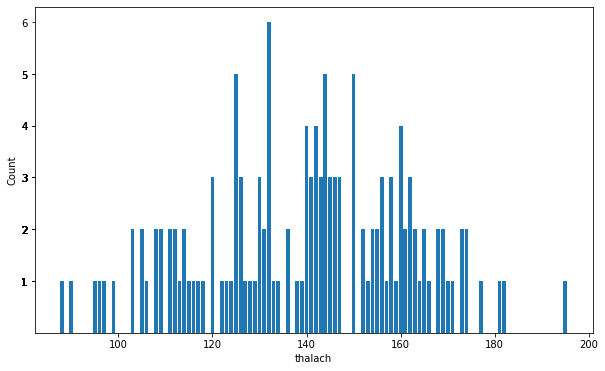

In [205]:
df_thalach0 = df[df['target']==0]['thalach'].value_counts().reset_index()
df_thalach0 = df_thalach0.rename(columns={"thalach": "count"})
df_thalach0 = df_thalach0.rename(columns={"index": "thalach"})

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(df_thalach0['thalach'],df_thalach0['count'])
ax.set_yticks(df_thalach0['count'])
ax.set_xlabel('thalach')
ax.set_ylabel('Count')
plt.show()

#### exang

In [127]:
df.exang.value_counts()

0    201
1     99
Name: exang, dtype: int64

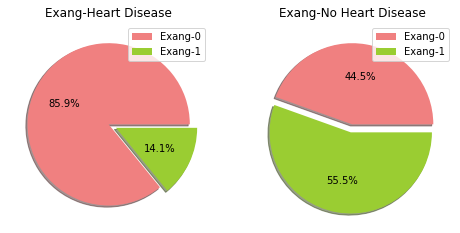

In [166]:
exang0 = df[(df['exang']==0)&(df['target']==1)]['exang'].count()
exang1 = df[(df['exang']==1)&(df['target']==1)]['exang'].count()

exang00 = df[(df['exang']==0)&(df['target']==0)]['exang'].count()
exang10 = df[(df['exang']==1)&(df['target']==0)]['exang'].count()

persentase = [exang0,exang1]
persentase0 = [exang00,exang10]
name = ['Exang-0','Exang-1']
colors = ['lightcoral','yellowgreen']

plt.figure('Exang', figsize=(8,5))
plt.subplot(121)
plt.pie(
    persentase,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.1)
)
plt.title('Exang-Heart Disease')
plt.legend(labels=name, loc="best")

plt.figure('Exang', figsize=(8,5))
plt.subplot(122)
plt.pie(
    persentase0,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.1)
)
plt.title('Exang-No Heart Disease')
plt.legend(labels=name, loc="best")



plt.show()

#### oldpeak

<Figure size 432x288 with 0 Axes>

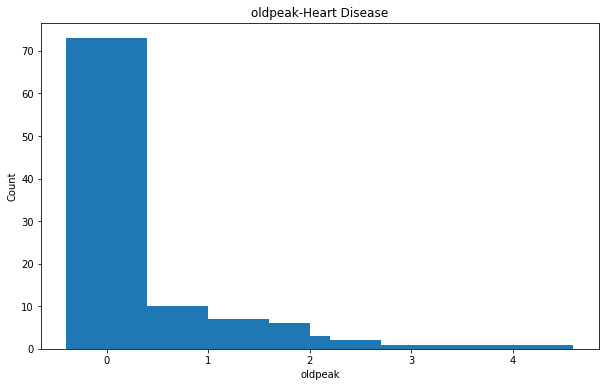

In [164]:
df_oldpeak1 = df[df['target']==1]['oldpeak'].value_counts().reset_index()
df_oldpeak1 = df_oldpeak1.rename(columns={"oldpeak": "count"})
df_oldpeak1 = df_oldpeak1.rename(columns={"index": "oldpeak"})

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(df_oldpeak1['oldpeak'],df_oldpeak1['count'])
ax.set_xlabel('oldpeak')
ax.set_ylabel('Count')
ax.set_title('oldpeak-Heart Disease')
plt.show()

<Figure size 432x288 with 0 Axes>

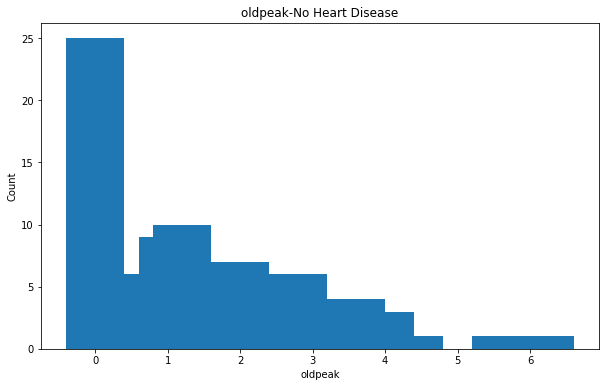

In [165]:
df_oldpeak0 = df[df['target']==0]['oldpeak'].value_counts().reset_index()
df_oldpeak0 = df_oldpeak0.rename(columns={"oldpeak": "count"})
df_oldpeak0 = df_oldpeak0.rename(columns={"index": "oldpeak"})


fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(df_oldpeak0['oldpeak'],df_oldpeak0['count'])
ax.set_xlabel('oldpeak')
ax.set_ylabel('Count')
ax.set_title('oldpeak-No Heart Disease')
plt.show()

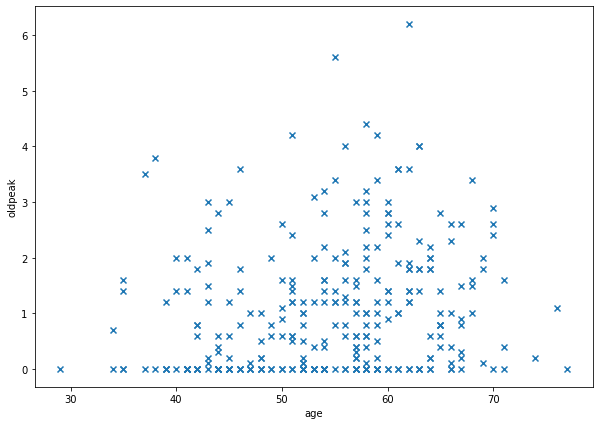

In [136]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(df['age'],df['oldpeak'], marker='x')
ax.set_ylabel('oldpeak')
ax.set_xlabel('age')
plt.show()

#### slope

In [138]:
df.slope.value_counts()

2    141
1    138
0     21
Name: slope, dtype: int64

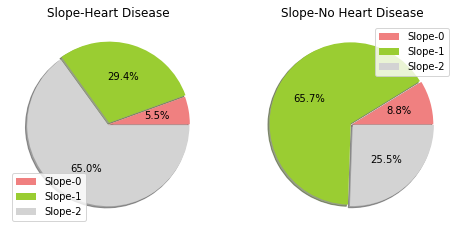

In [156]:
slope0 = df[(df['slope']==0)&(df['target']==1)]['slope'].count()
slope1 = df[(df['slope']==1)&(df['target']==1)]['slope'].count()
slope2 = df[(df['slope']==2)&(df['target']==1)]['slope'].count()

slope00 = df[(df['slope']==0)&(df['target']==0)]['slope'].count()
slope10 = df[(df['slope']==1)&(df['target']==0)]['slope'].count()
slope20 = df[(df['slope']==2)&(df['target']==0)]['slope'].count()

persentase = [slope0,slope1,slope2]
persentase0 = [slope00,slope10,slope20]
name = ['Slope-0','Slope-1','Slope-2']
colors = ['lightcoral','yellowgreen','lightgrey']

plt.figure('Slope', figsize=(8,5))
plt.subplot(121)
plt.pie(
    persentase,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.02,0.01)
)
plt.title('Slope-Heart Disease')
plt.legend(labels=name, loc="best")

plt.figure('Slope', figsize=(8,5))
plt.subplot(122)
plt.pie(
    persentase0,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0, 0.02,0.01)
)
plt.title('Slope-No Heart Disease')
plt.legend(labels=name, loc="best")



plt.show()

#### ca

In [145]:
df.ca.value_counts()

0    173
1     65
2     38
3     20
4      4
Name: ca, dtype: int64

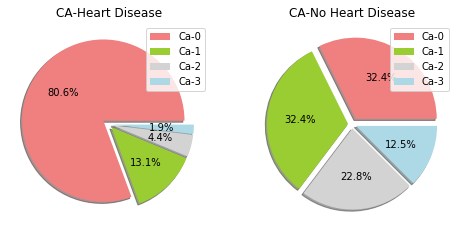

In [190]:
ca0 = df[(df['ca']==0)&(df['target']==1)]['ca'].count()
ca1 = df[(df['ca']==1)&(df['target']==1)]['ca'].count()
ca2 = df[(df['ca']==2)&(df['target']==1)]['ca'].count()
ca3 = df[(df['ca']==3)&(df['target']==1)]['ca'].count()

ca00 = df[(df['ca']==0)&(df['target']==0)]['ca'].count()
ca10 = df[(df['ca']==1)&(df['target']==0)]['ca'].count()
ca20 = df[(df['ca']==2)&(df['target']==0)]['ca'].count()
ca30 = df[(df['ca']==3)&(df['target']==0)]['ca'].count()

persentase = [ca0,ca1,ca2,ca3]
persentase0 = [ca00,ca10,ca20,ca30]
name = ['Ca-0','Ca-1','Ca-2','Ca-3']
colors = ['lightcoral','yellowgreen','lightgrey','lightblue']

plt.figure('CA', figsize=(8,5))
plt.subplot(121)
plt.pie(
    persentase,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0.08, 0.05,0.05,0.05)
)
plt.title('CA-Heart Disease')
plt.legend(labels=name, loc="best")

plt.subplot(122)
plt.pie(
    persentase0,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0.08, 0.05,0.05,0.05)
)
plt.title('CA-No Heart Disease')
plt.legend(labels=name, loc="best")



plt.show()

#### thal (thalium stress result)

In [188]:
df.thal.value_counts()

2    164
3    116
1     18
0      2
Name: thal, dtype: int64

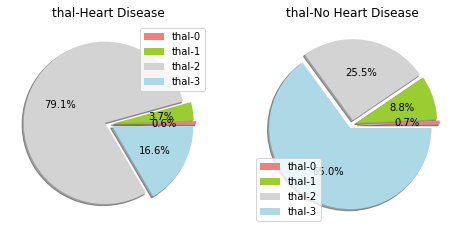

In [189]:
thal0 = df[(df['thal']==0)&(df['target']==1)]['thal'].count()
thal1 = df[(df['thal']==1)&(df['target']==1)]['thal'].count()
thal2 = df[(df['thal']==2)&(df['target']==1)]['thal'].count()
thal3 = df[(df['thal']==3)&(df['target']==1)]['thal'].count()

thal00 = df[(df['thal']==0)&(df['target']==0)]['thal'].count()
thal10 = df[(df['thal']==1)&(df['target']==0)]['thal'].count()
thal20 = df[(df['thal']==2)&(df['target']==0)]['thal'].count()
thal30 = df[(df['thal']==3)&(df['target']==0)]['thal'].count()

persentase = [thal0,thal1,thal2,thal3]
persentase0 = [thal00,thal10,thal20,thal30]
name = ['thal-0','thal-1','thal-2','thal-3']
colors = ['lightcoral','yellowgreen','lightgrey','lightblue']

plt.figure('Thal', figsize=(8,5))
plt.subplot(121)
plt.pie(
    persentase,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0.08, 0.05,0.05,0.05)
)
plt.title('thal-Heart Disease')
plt.legend(labels=name, loc="best")

plt.subplot(122)
plt.pie(
    persentase0,
    colors=colors,
    startangle=0,
    shadow=True,
    textprops={
        'size': 10,
        'color': 'black'
    },
    autopct = '%1.1f%%',
    explode = (0.08, 0.05,0.05,0.05)
)
plt.title('thal-No Heart Disease')
plt.legend(labels=name, loc="best")



plt.show()

### Insight Data berdasarkan Data Analysis dan Data Visualization

#### Data Analysis
27% orang yang merasakan typical chest pain terkena serangan jantung. Namun, typical chest pain memiliki resiko penyakit jantung terendah dibanding dengan chest pain lainnya

Terlihat disini, orang dengan max heart rate tinggi lebih berpotensi untuk terkena serangan jantung

#### Data Visualization
##### age
Pada kolom age terlihat bahwa dari umur 40 - 60 adalah range yang berpotensi untuk seseorang terkena serangan jantung.
##### sex
Dataset di dominasi laki-laki sebanyak 68% dan perempuan 32%. Lebih dari 70% perempuan di dataset memiliki potensi serangan jantung.
##### chest pain
Chest pain dengan kategori 2 (asymptotic) memiliki presentase tertinggi terkena serangan jantung.
##### trestbps
Dari blood pressure tidak begitu memperlihatkan adanya indikator yang memicu serangan jantung.
##### cholesterol
Kebanyakan orang yang terkena serangan jantung memiliki tingkat kolesterol 175-350.
##### fbs (blood sugar)
85% orang yang terkena serangan jantung memiliki gula darah rendah (<120mg/dl)
##### restecg
Hasil rest ECG kategori 2 menunjukan paling tidak rentan terhadap serangan jantung.
##### thalach (heart rate)
Terlihat dengan makin tinggi nya heart rate memicu resiko serangan jantung
##### exang (excercise include angina)
86% orang yang tidak berolahraga menggunakan angina beresiko terkena serangan jantung.
##### oldpeak
Orang dengan kategori oldpeak 0 rentan terhadap resiko serangan jantung.
##### slope
65% orang yang memiliki serangan jantung termasuk dalam kategori slope-2
##### ca
80% orang yang memiliki serangan jantung termasuk dalam kategori CA-0
##### thal
Sebanyak 80% orang yang terkena serangan jantung memiliki skor thalium stress yang dikategorikan di kategori 0

### Data Preprocessing

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       300 non-null    int64  
 1   sex       300 non-null    int64  
 2   cp        300 non-null    int64  
 3   trestbps  300 non-null    int64  
 4   chol      300 non-null    int64  
 5   fbs       300 non-null    int64  
 6   restecg   300 non-null    int64  
 7   thalach   300 non-null    int64  
 8   exang     300 non-null    int64  
 9   oldpeak   300 non-null    float64
 10  slope     300 non-null    int64  
 11  ca        300 non-null    int64  
 12  thal      300 non-null    int64  
 13  target    300 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.2 KB


In [208]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [209]:
df.target.value_counts()

1    163
0    137
Name: target, dtype: int64

In [214]:
df_ = df

#### Splitting Data

In [227]:
X = df_.drop(columns='target')
y = df_.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=42)

In [228]:
X_train.shape

(240, 12)

In [229]:
X_test.shape

(60, 12)

##### Data terlihat sudah cukup baik dan balance untuk bisa lanjut ke proses training.

### Feature Engineering & Feature Selection

In [230]:
df_.head()

,age,sex,cp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,354,0,1,163,1,0.6,2,0,2,1


##### Membuang Kolom trestbps karena tidak begitu relevan dengan output

In [231]:
df_.drop(columns=['trestbps'], inplace=True)

KeyError: "['trestbps'] not found in axis"

#### Scalling dengan Robust Scaler

In [232]:
scaler = RobustScaler()

In [233]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Training Model Machine Learning dengan 3 Algoritma Berbeda

#### Logistic Regression

In [331]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [332]:
model.score(X_train,y_train)

0.8458333333333333

In [333]:
model.score(X_test,y_test)

0.75

In [334]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.70      0.72        27
           1       0.76      0.79      0.78        33

    accuracy                           0.75        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.75      0.75      0.75        60



In [337]:
with open('heartsModel', 'wb') as ML:
    pickle.dump(model,ML)
with open('heartsModel', 'rb') as model:
    model1 = pickle.load(model)

In [338]:
model1.predict([[50,1,2,203,1,2,150,0,1.5,2,0,2]])[0]

0

#### KNearestNeighbor

In [240]:
modelKNN = KNeighborsClassifier(weights='distance', n_neighbors=5) 
modelKNN.fit(X_train, y_train)
y_predKNN = modelKNN.predict(X_test)

In [241]:
modelKNN.score(X_train,y_train)

1.0

In [242]:
modelKNN.score(X_test,y_test)

0.7666666666666667

In [244]:
print(classification_report(y_test,y_predKNN))

              precision    recall  f1-score   support

           0       0.78      0.67      0.72        27
           1       0.76      0.85      0.80        33

    accuracy                           0.77        60
   macro avg       0.77      0.76      0.76        60
weighted avg       0.77      0.77      0.76        60



#### Random Forest Classifier

In [246]:
modelRF = RandomForestClassifier()
modelRF.fit(X_train, y_train)
y_predRF = modelRF.predict(X_test)

In [247]:
modelRF.score(X_train,y_train)

1.0

In [248]:
modelRF.score(X_test,y_test)

0.8

In [249]:
print(classification_report(y_test,y_predKNN))

              precision    recall  f1-score   support

           0       0.78      0.67      0.72        27
           1       0.76      0.85      0.80        33

    accuracy                           0.77        60
   macro avg       0.77      0.76      0.76        60
weighted avg       0.77      0.77      0.76        60



### Hyper Parameter Tuning

#### Logistic Regression + Tuning

In [262]:
model = LogisticRegression()

In [263]:
params = {
    "penalty" : ['l1', 'l2'],
    "C": np.logspace(-4,4,20),
    "class_weight" : [{0: x, 1:1-x} for x in [0.1,0.15,0.2,0.25,0.3,0.05]]
}

In [264]:
model_tuning = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose = 1)
model_tuning.fit(X_train,y_train)
y_pred_tuning = model_tuning.predict(X_test)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   10.3s finished


In [276]:
model_tuning.best_params_

{'C': 29.763514416313132, 'class_weight': {0: 0.3, 1: 0.7}, 'penalty': 'l2'}

In [266]:
model_tuning.score(X_test, y_test)

0.7833333333333333

In [267]:
print(classification_report(y_test,y_pred_tuning))

              precision    recall  f1-score   support

           0       0.85      0.63      0.72        27
           1       0.75      0.91      0.82        33

    accuracy                           0.78        60
   macro avg       0.80      0.77      0.77        60
weighted avg       0.80      0.78      0.78        60



##### KNN + Tuning

In [321]:
params = {
    "n_neighbors" : range(1,50,2),
    "weights": ["uniform","distance"],
    "p" : [2,1]
}

In [327]:
modelKNN_tuning = GridSearchCV(KNeighborsClassifier(), params, cv=5, n_jobs=-1, verbose = 1)
modelKNN_tuning.fit(X_train,y_train)
y_predKNN_tuning = modelKNN_tuning.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


In [260]:
modelKNN_tuning.best_params_

{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

In [258]:
modelKNN_tuning.score(X_test, y_test)

0.8166666666666667

In [261]:
print(classification_report(y_test,y_predKNN_tuning))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78        27
           1       0.81      0.88      0.84        33

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.81        60
weighted avg       0.82      0.82      0.82        60



#### Random Forest Classifier + Tuning

In [268]:
modelRF = RandomForestClassifier()

In [286]:
params = {     'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [319]:
modelRF_tuning = GridSearchCV(modelRF, params, cv=5, n_jobs=-1, verbose = 1)
modelRF_tuning.fit(X_train,y_train)
y_predRF_tuning = modelRF_tuning.predict(X_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s


KeyboardInterrupt: 

In [288]:
modelRF_tuning.best_params_

{'bootstrap': True, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [289]:
modelRF_tuning.score(X_test, y_test)

0.7666666666666667

In [291]:
print(classification_report(y_test,y_predRF_tuning))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76        27
           1       0.83      0.73      0.77        33

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60



### Evaluation Metrics

In [296]:
#Logistic Regression + Tuning
pd.DataFrame(confusion_matrix(y_test,y_pred_tuning))

,0,1
0,17,10
1,3,30


In [297]:
print(classification_report(y_test,y_pred_tuning))

              precision    recall  f1-score   support

           0       0.85      0.63      0.72        27
           1       0.75      0.91      0.82        33

    accuracy                           0.78        60
   macro avg       0.80      0.77      0.77        60
weighted avg       0.80      0.78      0.78        60



In [298]:
#KNN + Tuning
pd.DataFrame(confusion_matrix(y_test,y_predKNN_tuning))

,0,1
0,20,7
1,4,29


In [299]:
print(classification_report(y_test,y_predKNN_tuning))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78        27
           1       0.81      0.88      0.84        33

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.81        60
weighted avg       0.82      0.82      0.82        60



In [301]:
#Random Forest + Tuning
pd.DataFrame(confusion_matrix(y_test,y_predRF_tuning))

,0,1
0,22,5
1,9,24


In [302]:
print(classification_report(y_test,y_predRF_tuning))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76        27
           1       0.83      0.73      0.77        33

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60



### Penjelasan & Fokus Evaluation Metrics

In [310]:
# Confusion Matrix KNN + Tuning
pd.DataFrame(confusion_matrix(y_test,y_predKNN_tuning))

,0,1
0,20,7
1,4,29


In [311]:
y_test.shape

(60,)

Tabel diatas adalah confusion matrix hasil dari prediksi X_test.<br>
Prediksi: 0 = Negative; 1 = Positive <br>
Aktual : 0 = False; 1 = True <br>
Bisa dilihat bahwa total test ada 60.<br>
Nilai dari Confusion matrix diatas:<br>
True Negative : 20<br>
False Positive : 7<br>
False Negative : 4<br>
True Positive : 29<br>

Untuk mengetahui apakah seseorang rentan terhadap penyakit jantung, maka model kita harus lebih fokus mengurangi `False Negative`. Karena kita tidak ingin jika kita di prediksi sehat, namun sebetulnya kita sakit.

In [312]:
# Classification model RF + Tuning
print(classification_report(y_test,y_predRF_tuning))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76        27
           1       0.83      0.73      0.77        33

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60



Precision 0 = Negative Predictive Value (NPV) -> 0.71 <br>
Precision 1 = Positive Predictive Value (PPV) ->0.83 <br>
Recal 0 = False Negative Rate (FNR) -> 0.81 <br>
Recal 1 = True Positive Rate (TPR) -> 0.73 <br>

Jadi model harus berfokus kepada Recal 0. Dimana dengan model KNN + tuning ini menghasilkan nilai FNR = 0,81 yang bisa dikatakan sudah cukup baik untuk memprediksi `False Negative`. 


#### Export Model

In [317]:
with open('heartsModelRF', 'wb') as ML:
    pickle.dump(model,ML)

In [318]:
joblib.dump(model,'ModelJoblib')

['ModelJoblib']